In [31]:
from modules import modeling as mod
from modules import visualitzation 
from modules import lsf


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix, classification_report
import pandas as pd
import numpy as np
import os
import sys
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

module_path = os.path.abspath(os.path.join(os.pardir,'src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
building_df = pd.read_pickle("../processed_data/datacleaned.pkl")

In [33]:
building_df.shape

(762106, 46)

nominals might be change into dummies

In [34]:
dummy_1 = mod.dummify(building_df, 'ward_id')
dummy_2 = mod.dummify(building_df, 'land_surface_condition')
dummy_3 = mod.dummify(building_df, 'foundation_type')
dummy_4 = mod.dummify(building_df, 'roof_type')
dummy_5 = mod.dummify(building_df, 'ground_floor_type')
dummy_6 = mod.dummify(building_df, 'other_floor_type')
dummy_7 = mod.dummify(building_df, 'position')
dummy_8 = mod.dummify(building_df, 'plan_configuration')
dummy_9 = mod.dummify(building_df, 'legal_ownership_status')
dummy_10 = mod.dummify(building_df, 'vdcmun_id')
dummy_11 = mod. dummify(building_df, 'district_id')

In [35]:
# defining the list of features to drop
drop_list= ['ward_id', 'land_surface_condition', 'foundation_type',
       'roof_type', 'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration','legal_ownership_status', 'land_surface_condition_num', 
            'foundation_type_num', 'roof_type_num',
       'ground_floor_type_num', 'other_floor_type_num', 'position_num', 
            'plan_configuration_num', 'legal_ownership_status_num', 
            'has_secondary_use', 'has_geotechnical_risk', 'district_id', 'vdcmun_id']
len(drop_list)

21

As analyzed in the visualizations we should remove has_secondary_use and has_geotechnical_risk.

In [36]:

drop_list= ['ward_id', 'land_surface_condition', 'foundation_type',
       'roof_type', 'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration','legal_ownership_status', 'land_surface_condition_num', 
            'foundation_type_num', 'roof_type_num',
       'ground_floor_type_num', 'other_floor_type_num', 'position_num', 
            'plan_configuration_num', 'legal_ownership_status_num', 
            'has_secondary_use', 'has_geotechnical_risk', 'district_id', 'vdcmun_id']
len(drop_list)

21

In [37]:
building_df.drop(columns= drop_list, axis=1, inplace=True)

KeyError: "['land_surface_condition_num', 'foundation_type_num', 'roof_type_num', 'ground_floor_type_num', 'other_floor_type_num', 'position_num', 'plan_configuration_num', 'legal_ownership_status_num'] not found in axis"

In [38]:
df_list= [building_df, dummy_1 , dummy_2 , dummy_3 , dummy_4 , 
          dummy_5 , dummy_6 , dummy_7 , dummy_8 , dummy_9, dummy_10, dummy_11]
for df in df_list:
    print(df.shape)

(762106, 46)
(762106, 18)
(762106, 2)
(762106, 4)
(762106, 2)
(762106, 4)
(762106, 3)
(762106, 3)
(762106, 9)
(762106, 3)
(762106, 12)
(762106, 10)


In [39]:
X = pd.concat(df_list, axis=1)
y = X['target']

X.drop(['target'], axis=1, inplace=True)

print(X.shape)
print(y.shape)

(762106, 115)
(762106,)


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, test_size=0.4)

print("Training set - Features: ", X_train.shape, "Target: ", y_train.shape,)
print("Test set - Features: ", X_test.shape, "Target: ",y_test.shape,)
print('============================================ ')
print(y_train.value_counts(normalize = True))
print(y_test.value_counts(normalize = True))

Training set - Features:  (457263, 115) Target:  (457263,)
Test set - Features:  (304843, 115) Target:  (304843,)
3    0.603718
1    0.217566
2    0.178716
Name: target, dtype: float64
3    0.60212
1    0.21847
2    0.17941
Name: target, dtype: float64


Proportion of type of Building damage
3    60.31
1    21.79
2    17.90
Name: target, dtype: float64


FileNotFoundError: [Errno 2] No such file or directory: './images/target_variable_class_imbalance.png'

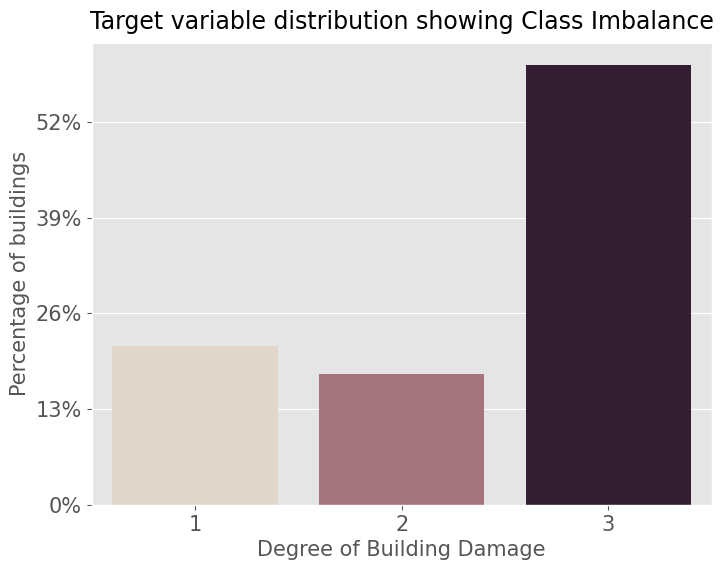

In [41]:
title = 'Target variable distribution showing Class Imbalance'
figname = 'target_variable_class_imbalance'
lsf.target_var(building_df, title, figname, xmax = 762106)

There is some level of class imbalance. 60% of the buildings in the dataset have severe or Grade 3 damage, while about 22% are buildings of Grade 1 with minor damages and 18% of buildings are of Grade 2 or major damages.
To deal with this we will use a composition of downsampling the majority class which is class 3 and upsampling the minority class which is class 2.

In [42]:
training = pd.concat([X_train, y_train], axis=1)

grade1 = training[training['target']==1]
grade2 = training[training['target']==2]
grade3 = training[training['target']==3]
training['target'].value_counts()

3    276058
1     99485
2     81720
Name: target, dtype: int64

In [43]:
downsampled_grade3 = resample(grade3,
                      replace=False,
                      n_samples = len(grade1)+30000,
                      random_state = 100)

downsampled_grade3.shape

(129485, 116)

In [44]:
upsample_grade2 = resample(grade2,
                          replace= True,
                          n_samples = len(grade1),
                          random_state = 100)

upsample_grade2.shape

(99485, 116)

In [45]:
resampled = pd.concat([downsampled_grade3, grade1, upsample_grade2])

resampled['target'].value_counts(normalize=True)

3    0.394224
1    0.302888
2    0.302888
Name: target, dtype: float64

Difference more stables now 

In [46]:
y_train_resampled = resampled['target']
X_train_resampled = resampled.drop(columns = ['target'], axis= 1)
X_train_resampled.shape

(328455, 115)

In [47]:
from sklearn.preprocessing import StandardScaler

columns = X_train_resampled.columns

scaler = StandardScaler()  
scaler.fit(X_train_resampled)

X_train_scaled_values = scaler.transform(X_train_resampled.values)  
X_test_scaled_values = scaler.transform(X_test.values)

X_train_scaled = X_train_resampled.copy()
X_test_scaled = X_test.copy()

X_train_scaled[columns]= X_train_scaled_values
X_test_scaled[columns] = X_test_scaled_values

ValueError: could not convert string to float: 'Flat'

In [ ]:
scoring = {'recall': mod.scorer_recall()}

In [ ]:
# Staging the Logistic Regression model object
lr = LogisticRegression(random_state=100, multi_class='multinomial', solver= 'saga' )

#Defining the parameters to use in the gridsearch
params = {'C':[0.1, 1, 5, 10], 'max_iter': [1000, 10000]}

#Staging the gridsearch 
gs_lr = GridSearchCV(lr, param_grid=params, scoring=scoring, cv=3, verbose=2, refit='recall', n_jobs=-1)

In [ ]:
# fitting the grid search to the train sets
gs_lr.fit(X_train_scaled, y_train_resampled)

NameError: name 'X_train_scaled' is not defined

In [48]:
gs_lr.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'